In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

### 1D Gaussian distribution approximation using GAN

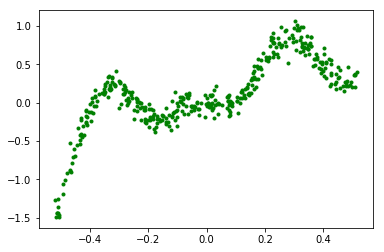

In [2]:
x = np.linspace(0,1,400)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - x.mean() # good practice to zero-center x in linear mapping
sortindx = np.argsort(x)
x = x[sortindx]
y = y[sortindx]
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)
plt.scatter(x, y, marker='.', color='g')

In [3]:
data = np.c_[xx,yy]
data.shape

(400, 2)

In [4]:
# ## Global bins defined here
# data_range = 5
# global_bins = np.linspace(-data_range, data_range, n_bins)
# global_xvals = (global_bins[1:] + global_bins[:-1])/2.

# prob,bins = np.histogram(data_sample, global_bins, density=True)
# plt.plot(global_xvals, prob)

In [5]:
# Noise distribution -> Uniform Distribution
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        offset = np.random.random(num_samples) * 0.01
        samples = np.linspace(-self.data_range, self.data_range, num_samples) + offset
        return samples

In [6]:
data_range = 1
noise = NoiseDistribution(data_range)
noise_sample = noise.sample(400)

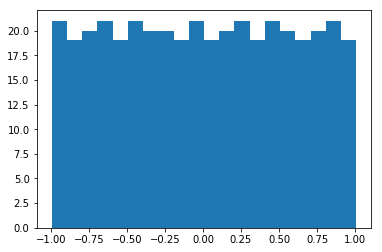

In [7]:
n_bins=20
plt.hist(noise_sample, bins=n_bins)
plt.show()

In [30]:
# Generator model
class Generator(nn.Module):
    def __init__(self,):
        super().__init__()
        
        self.actf= nn.LeakyReLU()
#         self.actf = nn.ReLU()
#         self.actf = nn.Tanh()
        self.layer0 = nn.Linear(2, 20)
        self.layer1 = nn.Linear(20, 20)
        self.layer2 = nn.Linear(20,2)

    def forward(self, x):
        x = self.layer0(x)
        x = self.actf(x)
        x = self.layer1(x)
        x = self.actf(x)
        x = self.layer2(x)
        return x

In [31]:
# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self,):
        super().__init__()

        self.actf= nn.LeakyReLU()
#         self.actf= nn.ReLU()
#         self.actf= nn.Tanh()
        self.layer0 = nn.Linear(2, 20)
        self.layer1 = nn.Linear(20, 20)
        self.layer2 = nn.Linear(20,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer0(x)
        x = self.actf(x)
        x = self.layer1(x)
        x = self.actf(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

In [32]:
G = Generator()
D = Discriminator()

In [33]:
## For Generated values
noise_sample = np.c_[noise.sample(200), noise.sample(200)]
gen_data = G.forward(torch.Tensor(noise_sample)).data.numpy()
plt.scatter(gen_data[:,0],gen_data[:,1])

In [37]:
# Optimizers
learning_rate=0.0001
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
loss_func = torch.nn.BCELoss() # Binary Cross Entropy

D_losses = []
G_losses = []

In [40]:
batch_size = 300
num_epochs = 100000 #3000
num_samples = 10000

In [41]:
y_real_ = torch.ones([batch_size, 1])
y_fake_ = torch.zeros([batch_size, 1])

%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for epoch in range(num_epochs):
    
    # Get Real samples
    x_ = data[np.random.randint(0, len(data), batch_size)]
    x_ = torch.Tensor(x_)
    # Train discriminator with real data
    D_real_output = D(x_)
    D_real_loss = loss_func(D_real_output, y_real_)

    # Generate samples
    z_ = np.c_[noise.sample(batch_size), noise.sample(batch_size)]
    z_ = torch.Tensor(z_)
    z_ = G(z_)
    
    # Train discriminator with fake data
    D_fake_output = D(z_)
    D_fake_loss = loss_func(D_fake_output, y_fake_)

    # Back propagation
    D_loss = (D_real_loss + D_fake_loss)#/2
    D.zero_grad()
    G.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    # Train generator
    z_ = np.c_[noise.sample(batch_size), noise.sample(batch_size)]
    z_ = torch.Tensor(z_)
    z_ = G(z_)

    D_fake_output = D(z_)
    G_loss = loss_func(D_fake_output, y_real_) # if discriminator fails, generator wins

    # Back propagation
    D.zero_grad()
    G.zero_grad()
    G_loss.backward()
    G_optimizer.step()

    # Save loss values for plot
    D_losses.append(D_loss.data.numpy())
    G_losses.append(G_loss.data.numpy())

    if epoch % 100 == 0:
        print(epoch, D_loss.data.numpy(), G_loss.data.numpy())
        ax.clear()
        
        ## For Generated values
        noise_sample = np.c_[noise.sample(200), noise.sample(200)]
        gen_data = G.forward(torch.Tensor(noise_sample)).data.numpy()
        plt.scatter(gen_data[:,0],gen_data[:,1], marker='.', label='generated data')

        ## For Real Data
        plt.scatter(data[:,0],data[:,1], marker='.', label='real data')

        fig.canvas.draw()
        plt.pause(0.01)

0 1.3852228 0.69271356
100 1.3828504 0.69442666
200 1.3790011 0.6942602
300 1.3757553 0.69599897
400 1.3738898 0.69598144
500 1.3831521 0.69358706
600 1.3508947 0.71725345
700 1.337429 0.70855707
800 1.4311986 0.6601778
900 1.4172034 0.6914477
1000 1.3917217 0.7034036
1100 1.3748759 0.7108603
1200 1.3631251 0.70531857
1300 1.3755299 0.6918368
1400 1.3917646 0.6905278
1500 1.3729761 0.69798565
1600 1.3712213 0.70609623
1700 1.3466148 0.7300295
1800 1.3165743 0.74812
1900 1.3102665 0.7331956
2000 1.4173858 0.66804516
2100 1.4382331 0.69671947
2200 1.3895146 0.7146639
2300 1.3742087 0.7030599
2400 1.3868268 0.6834686
2500 1.3752973 0.6794973
2600 1.3928611 0.6805896
2700 1.3824232 0.7050975
2800 1.3691254 0.70672345
2900 1.3663335 0.7003519
3000 1.4006724 0.68786645
3100 1.3943696 0.6981952
3200 1.3787875 0.69739074
3300 1.3780663 0.69808125
3400 1.3869758 0.69401926
3500 1.3930186 0.6917446
3600 1.3852191 0.69529533
3700 1.3832932 0.69537973
3800 1.3854468 0.6917773
3900 1.3870533 0.6898

31700 1.2505777 0.91127414
31800 1.4627614 0.6169903
31900 1.4627903 0.56995654
32000 1.432661 0.5813531
32100 1.3498929 0.6513314
32200 1.2521901 0.72920746
32300 1.258139 0.72787046
32400 1.2499323 0.72749627
32500 1.2212973 0.7593762
32600 1.6490321 0.51843697
32700 1.3435476 0.93838066
32800 1.259052 1.0272442
32900 1.1858945 1.1178815
33000 1.1777737 1.0541867
33100 1.3930326 0.6981747
33200 1.5694082 0.51273584
33300 1.4797001 0.5476642
33400 1.3182158 0.6574485
33500 1.2267495 0.74001855
33600 1.2330446 0.75465727
33700 1.269228 0.7042558
33800 1.5718522 0.5269152
33900 1.4213045 0.7938106
34000 1.3125437 0.9588213
34100 1.2095654 1.0335475
34200 1.2314931 0.9513137
34300 1.484123 0.632674
34400 1.4866369 0.56317383
34500 1.4113781 0.595374
34600 1.341371 0.6392767
34700 1.2656947 0.6945582
34800 1.2396538 0.7395034
34900 1.2549846 0.7219288
35000 1.5423322 0.5700904
35100 1.4103163 0.7773592
35200 1.3201079 0.94801074
35300 1.244231 0.98890597
35400 1.2042179 1.0198588
35500 1.

63000 1.666745 0.5063027
63100 1.3791168 0.9032289
63200 1.3301029 0.9145004
63300 1.3233044 0.84545535
63400 1.3770041 0.69679236
63500 1.3822799 0.6458276
63600 1.4178498 0.6041641
63700 1.2781898 0.73113406
63800 1.1711292 0.82470936
63900 1.2355876 0.74284226
64000 1.2326527 0.73192257
64100 1.6645601 0.56594676
64200 1.4143666 0.91741943
64300 1.3011072 1.0221916
64400 1.2761728 0.9529359
64500 1.3555174 0.7349863
64600 1.4342597 0.6180764
64700 1.6287521 0.47149155
64800 1.2036717 0.7807292
64900 0.92939126 1.1566136
65000 1.2496905 0.6258404
65100 1.3747034 0.6100789
65200 1.7168199 0.4506751
65300 1.4669907 0.8174213
65400 1.3020675 1.0495433
65500 1.2216325 1.1163604
65600 1.4729034 0.6673847
65700 1.4993911 0.59403116
65800 1.4315524 0.60994744
65900 1.3642488 0.64295113
66000 1.3304856 0.6622177
66100 1.2882102 0.7094951
66200 1.2138901 0.75961614
66300 1.2701087 0.7018823
66400 1.2551302 0.73365617
66500 1.7485533 0.47554147
66600 1.4175344 0.88638306
66700 1.294524 1.05343

TclError: invalid command name "pyimage164"

In [ ]:
%matplotlib inline
## For Generated values
noise_sample = noise.sample(num_samples)
gen_data = G.forward(torch.Tensor(noise_sample.reshape(-1,1))).data.numpy()
plt.scatter(gen_data[:,0],gen_data[:,1], marker='.', label='generated data')
## For Real Data
plt.scatter(data[:,0],data[:,1], marker='.', label='real data')